In [ ]:
!pip install scikit-plot

In [ ]:
import pandas as pd
import numpy as np
import scikitplot
import random
import seaborn as sns
import keras
import os
from matplotlib import pyplot
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
import warnings
from tensorflow.keras.models import Sequential
from keras import regularizers
from keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.optimizers import Adam,RMSprop,SGD,Adamax
from keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.utils import plot_model
from keras.layers import Conv2D, MaxPool2D, Flatten,Dense,Dropout,BatchNormalization,MaxPooling2D,Activation,Input
from sklearn.preprocessing import StandardScaler
warnings.simplefilter("ignore")
from keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from keras.regularizers import l1, l2
import plotly.express as px
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from skimage import io
from skimage.transform import resize

### Loading Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = pd.read_csv("/content/drive/MyDrive/Data/fer2013.csv")
data.shape

(35887, 3)

### Data pre-processing

In [ ]:
# List of class labels for emotions
CLASS_LABELS  = ['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sadness', "Surprise"]

# Create a bar chart
fig = px.bar(x = CLASS_LABELS,
             y = [list(data['emotion']).count(i) for i in np.unique(data['emotion'])] ,
             color = np.unique(data['emotion']) ,
             color_continuous_scale="Emrld")
fig.update_xaxes(title="Emotions")
fig.update_yaxes(title = "Number of Images")
fig.update_layout(showlegend = True,
    title = {
        'text': 'Train Data Distribution ',
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
fig.show()

In [ ]:
data = data.sample(frac=1)

# One-hot encoding the data
labels = to_categorical(data[['emotion']], num_classes=7)

# Convert pixels to numpy array
train_pixels = data["pixels"].astype(str).str.split(" ").tolist()
train_pixels = np.uint8(train_pixels)

pixels = train_pixels.reshape((35887*2304,1))
scaler = StandardScaler()
pixels = scaler.fit_transform(pixels)

# Reshape the data to (48, 48)
pixels = train_pixels.reshape((35887, 48, 48,1))

In [ ]:
labels = data['emotion']
pixels = data['pixels'].apply(lambda x: np.array(x.split(), dtype='float32'))

# Convert labels to numerical values
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

### Split data to Train and Test

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(pixels, labels, test_size=0.2, random_state=42)

In [ ]:
# Resize images to a common size
X_train_resized = [resize(x.reshape(48, 48), (64, 64), mode='constant') for x in X_train]
X_test_resized = [resize(x.reshape(48, 48), (64, 64), mode='constant') for x in X_test]

# Flatten the resized images
X_train_flat = [x.flatten() for x in X_train_resized]
X_test_flat = [x.flatten() for x in X_test_resized]

###  Initialize the Random Forest Classifier

In [ ]:
# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=10, random_state=42)

### Training

In [ ]:
train_accuracy = []
test_accuracy = []

# Train the Random Forest model
for n_estimators in range(1, 11):
    rf_classifier.n_estimators = n_estimators
    rf_classifier.fit(X_train_flat, y_train)

    # Predict on training and testing data
    train_pred = rf_classifier.predict(X_train_flat)
    test_pred = rf_classifier.predict(X_test_flat)

    # Calculate accuracy on training and testing data
    train_acc = accuracy_score(y_train, train_pred)
    test_acc = accuracy_score(y_test, test_pred)

    train_accuracy.append(train_acc)
    test_accuracy.append(test_acc)

    print(f"Number of Trees: {n_estimators}, Train Accuracy: {train_acc:.2f}, Test Accuracy: {test_acc:.2f}")

Number of Trees: 1, Train Accuracy: 0.74, Test Accuracy: 0.29
Number of Trees: 2, Train Accuracy: 0.74, Test Accuracy: 0.28
Number of Trees: 3, Train Accuracy: 0.86, Test Accuracy: 0.31
Number of Trees: 4, Train Accuracy: 0.91, Test Accuracy: 0.34
Number of Trees: 5, Train Accuracy: 0.94, Test Accuracy: 0.36
Number of Trees: 6, Train Accuracy: 0.96, Test Accuracy: 0.36
Number of Trees: 7, Train Accuracy: 0.97, Test Accuracy: 0.38
Number of Trees: 8, Train Accuracy: 0.98, Test Accuracy: 0.39
Number of Trees: 9, Train Accuracy: 0.99, Test Accuracy: 0.39
Number of Trees: 10, Train Accuracy: 0.99, Test Accuracy: 0.40


### Results

In [ ]:
# Make predictions on the test data
y_pred = rf_classifier.predict(X_test_flat)

In [ ]:
# Convert predicted class labels back to names
y_pred_names = label_encoder.inverse_transform(y_pred)

# Convert true class labels back to names
y_test_names = label_encoder.inverse_transform(y_test)

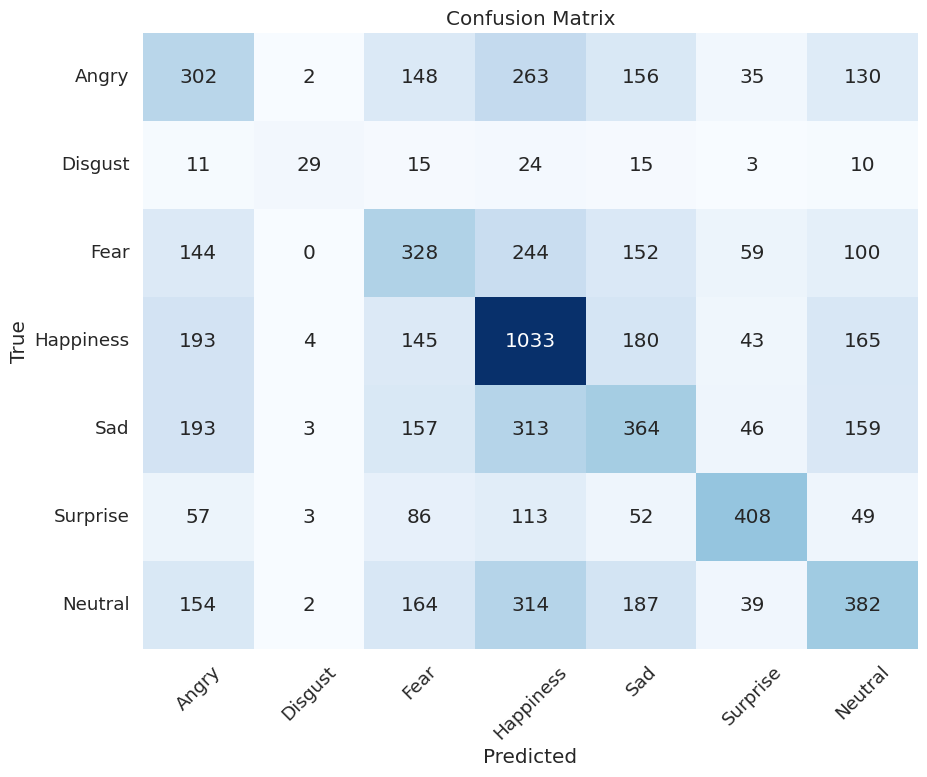

In [ ]:
confusion = confusion_matrix(y_test, y_pred)

class_names = ["Angry", "Disgust", "Fear", "Happiness", "Sad", "Surprise", "Neutral"]

plt.figure(figsize=(10, 8))

sns.set(font_scale=1.2)
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=class_names, yticklabels=class_names)

plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.xticks(np.arange(len(class_names)) + 0.5, class_names, rotation=45)
plt.yticks(np.arange(len(class_names)) + 0.5, class_names, rotation=0)
plt.show()

In [ ]:
# Calculate accuracy
accuracy = accuracy_score(y_test_names, y_pred_names)

report = classification_report(y_test_names, y_pred_names, target_names=class_names)

print(f'Final Accuracy: {accuracy:.2f}')
print(report)

Final Accuracy: 0.40
              precision    recall  f1-score   support

       Angry       0.29      0.29      0.29      1036
     Disgust       0.67      0.27      0.39       107
        Fear       0.31      0.32      0.32      1027
   Happiness       0.45      0.59      0.51      1763
         Sad       0.33      0.29      0.31      1235
    Surprise       0.64      0.53      0.58       768
     Neutral       0.38      0.31      0.34      1242

    accuracy                           0.40      7178
   macro avg       0.44      0.37      0.39      7178
weighted avg       0.40      0.40      0.39      7178

